# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from Kaggle although we have taken steps to pull this data into a public s3 bucket: s3://sayerspyspark/*business.json

# Installation and Initial Setup
I'll begin by installing the necessary libraries that I'll need to conduct my analysis. These include Pandas, Matplotlib and Seaborn. 

In [1]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1588476374938_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

## Importing
Now, I'll import the installed packages from the previous block below and additionally the pyspark.sql.functions required for working with the data later.

In [2]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sb
from pyspark.sql.functions import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data
We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [3]:
df = spark.read.json('s3://sayerspyspark/*business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data
Below, see the number of rows and columns in our dataset.

In [4]:
print(f'Columns: {len(df.columns)} | Rows: {df.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209,393

Below, see the DataFrame schema.

In [5]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Now, to display the first 5 rows with the following columns:

* business_id
* name
* city
* state
* categories

In [6]:
df.select("business_id","name","city","state","categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

This will essentially be the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

How many businesses are categorized as Active Life, for instance
What are the top 20 most popular categories available?

## Association Table
We need to "break out" these categories from the business ids. One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

In [7]:
x1 = df.select(col("business_id"), explode(split(col("categories"), ",")).alias('categories'))
x1=x1.withColumn('categories', ltrim(x1.categories))
x1.show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

# Total Unique Categories
Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, I'll implement the code necessary to calculate this figure.

In [8]:
x1.select("categories").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

In [9]:
x1.select('categories').groupby(x1.categories).count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|         categories|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

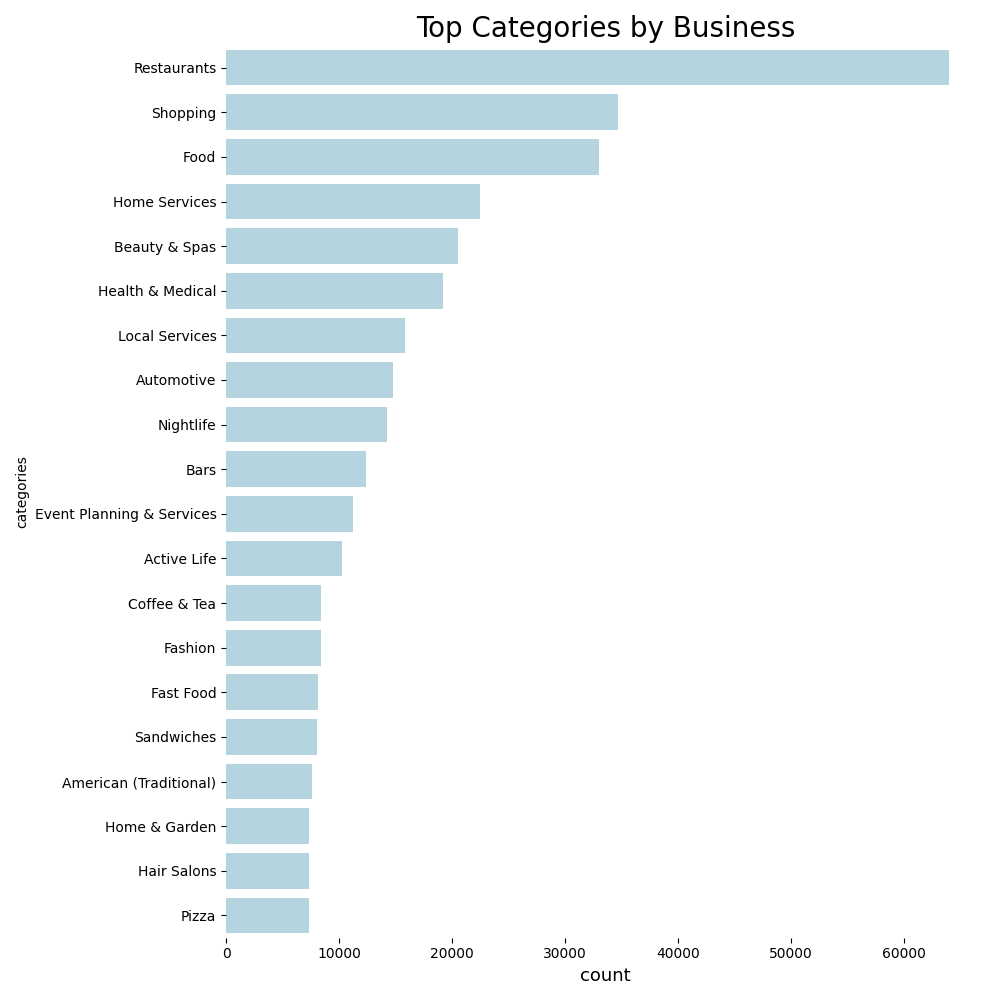

In [10]:
zx = x1.select('categories').groupby(x1.categories).count().sort(desc("count")).limit(20).toPandas()

plt.clf()
plt.figure(figsize=(10,10))
plt.title('Top Categories by Business', fontsize=20)
#plt.yticks(fontsize=12)
#plt.xticks(fontsize=12)
plt.xlabel('',fontsize=13)
plt.xlabel('category',fontsize=13)
plt.box(False)
plt.gca().invert_yaxis()
sb.barplot(zx['count'],zx['categories'],color="lightblue")
plt.tight_layout()
%matplot plt

# Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

# Loading User Data
I'll begin by loading the user data set from S3 and printing schema to determine what data is available.

In [11]:
udf = spark.read.json('s3://sayerspyspark/*review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
udf.printSchema()
#print(f'Columns: {len(udf.columns)} | Rows: {udf.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [13]:
udf.select("business_id","stars").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who **took the time to submit a written review.**

In [14]:
from pyspark.sql.functions import col, avg
udx = udf.where(col("text").isNotNull()).groupby(udf.business_id).agg(avg(col("stars")))
udx.show(5)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by business_id.

Let's see a few of these:

In [15]:
from pyspark.sql.functions import desc

udy = udf.groupby(udf.business_id).agg(avg(col("stars")))
new_df = df.join(udx, on=['business_id'])
new_df2= df.join(udy,on=['business_id'])
#new_df = new_df.select("avg(stars)","stars","name","city","state").sort(desc("""avg(stars)"""))
#new_df2 = new_df2.select("avg(stars)","stars","name","city","state").sort(desc("""avg(stars)"""))
new_df.select("""avg(stars)""","stars","name","city","state").sort(desc("""avg(stars)""")).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|Carbonation Craft...|Cornelius|   NC|
|       5.0|  5.0|PartyZams Singing...|Las Vegas|   NV|
|       5.0|  5.0|Design Array Gara...|   Peoria|   AZ|
|       5.0|  5.0|Andre Agassi Coll...|Las Vegas|   NV|
|       5.0|  5.0|       The Elf Squad|Charlotte|   NC|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows

Please note that as the average stars are equal for any Business which with the maximum value, rerunning the .show() command will quasi-randomly generate a new and different list every time it is run. 

Now, I'll compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

$row['avg(stars)'] - row['stars']) / row['stars']$

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [16]:
x = new_df.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
y =   new_df2.select("avg(stars)","stars","name","city","state").sort("""avg(stars)""",ascending=False)
new_dfx = x.withColumn("skew", ((x["""avg(stars)"""]-y["stars"])/x["stars"])).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

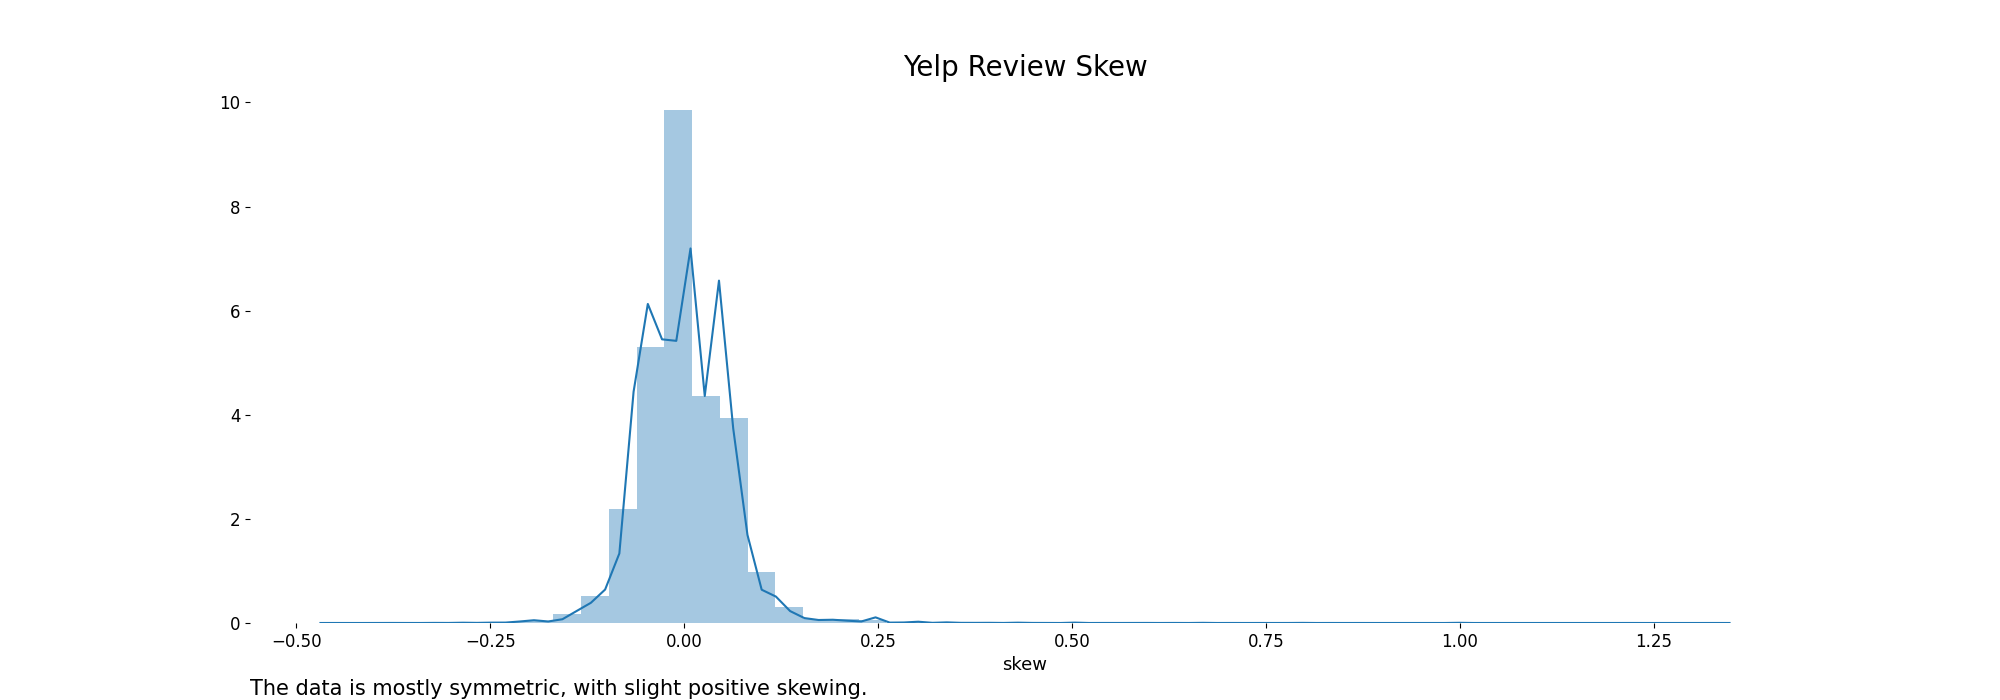

In [17]:
plt.clf()
plt.figure(figsize=(20,7))
plt.title('Yelp Review Skew', fontsize=20)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('',fontsize=13)
plt.box(False)
hist_kws=dict(alpha=0.2)
sb.distplot(new_dfx["skew"])
plt.annotate("The data is mostly symmetric, with slight positive skewing.",(0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top',fontsize=15)
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph.

---
Symmetric data with slightly more data on the left and a longer right tail suggests very slight skewing.  This means there is a largely insignificant positive skew, suggesting that a small number of people rate positively without ever leaving a review or that people that write reviews may leave generally slightly more negative ratings.

# Should the Elite be Trusted? (Or, some other analysis of your choice)
For the final portion I choose to do an analysis of the difference between user rating behavior in populations of users who had never attained the status of Yelp Elite and those who had spent varying periods of time as an Elite. This analysis leverages the User and Reviews data sets. 

I start by loading data from each file. 

In [18]:
users = spark.read.json('s3://sayerspyspark/*user.json')
reviews= spark.read.json('s3://sayerspyspark/*review.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Next, I'll transform the data into useful forms, such as by decompressing nested data (such as years with elite status), counting (such as counting the years spent as an elite), averaging (such as averaging the number of stars a given users gives). After that, I join the results of these transformations and create Pandas dataframes with them so that they can be easily visually displayed and scanned for patterns. 

In [19]:
#Professor, the rubric states that I have to join these tables, so I am, even if I won't use the resulting data directly
userreviews = reviews.join(users,on="user_id")

userselite = users.select(col("user_id"), explode(split(col("elite"), ",")).alias('elite_yrs'))
userselitecnt = userselite.groupby(userselite.user_id).agg(count(col("elite_yrs")).alias("yrs_elite"))
userselitecnt = userselitecnt.withColumn("yrs_elite", userselitecnt['yrs_elite']-1)
avgreview  = reviews.groupby(col("user_id")).agg(avg("stars").alias("avg_stars"))
revcount = reviews.groupby("user_id","stars").agg(count("stars").alias("rev_count"))
revmax = revcount.groupby("user_id").agg(max("rev_count").alias("rev_count"))
revmode = revmax.join(revcount, on=["user_id","rev_count"])

revmode = revmode.withColumnRenamed("stars","stars2")
elitetrust = userselitecnt.join(avgreview, on="user_id").toPandas()
elitemode = userselitecnt.join(revmode, on="user_id").groupby('yrs_elite','stars2').agg(count("stars2")).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now, we evaluate whether Elite Ratings tend to be higher. In this portion of the analysis, I'll be reviewing average rating for each user and the years they spent as an Elite. If there is a relationship between rating habits and Elite status, I expect to see clear trending in average scores by years spent as an Elite.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

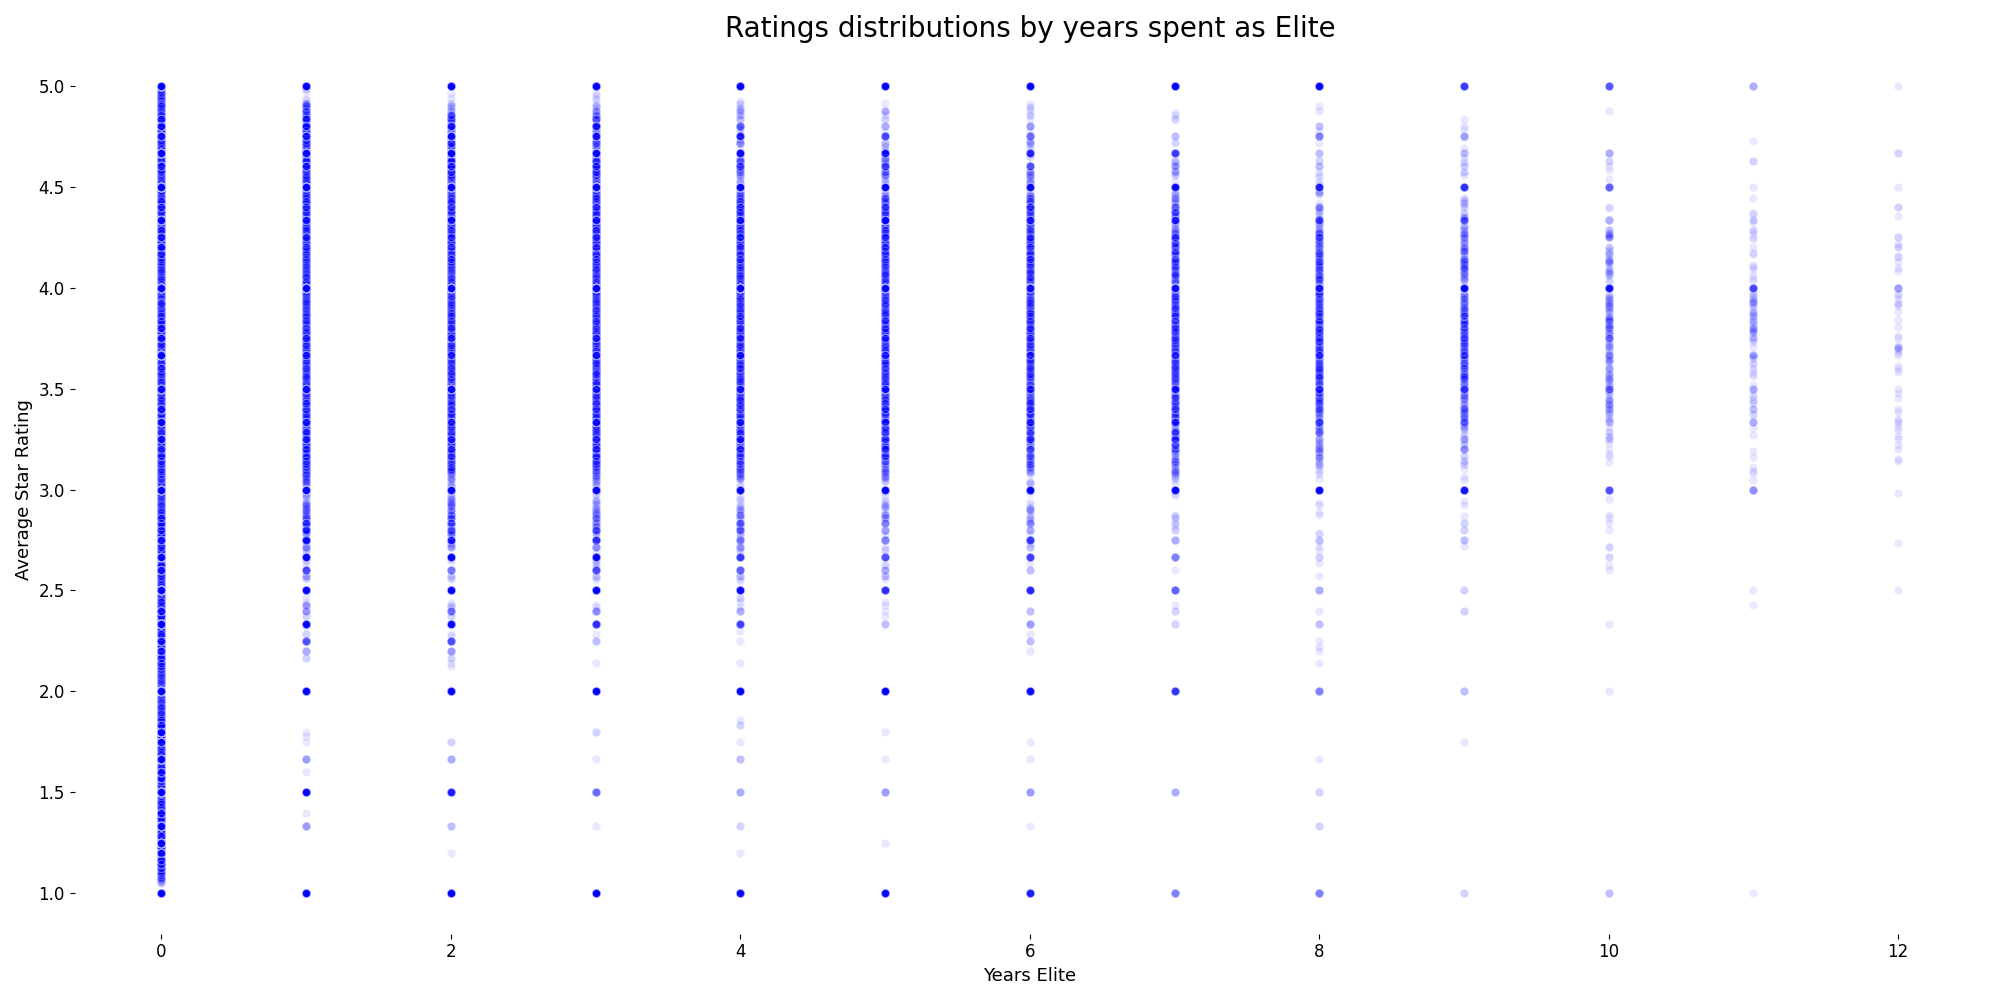

In [20]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Ratings distributions by years spent as Elite', fontsize=20)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.box(False)
#sb.scatterplot(elitemode['yrs_elite'],elitemode['stars2'],color="red")
sb.scatterplot(elitetrust['yrs_elite'],elitetrust['avg_stars'],alpha=0.09, color="blue")
plt.xlabel("Years Elite",fontsize=13)
plt.ylabel("Average Star Rating", fontsize = 13)
plt.tight_layout()
%matplot plt

The higher the number of years a given user has spent as an Elite, the higher their average rating is. This suggests not only that Elites are more likely to give good ratings but also may indicate that people that give good ratings may be more likely to be chosen as Elites. Comparatively, the distribution of the average scores of users who ahve never been Elite runs the full gamut.

---

Next, we'll secure this partial conclusion by looking at the mode per user per number of years spent elite. In other words, we want to compare alike quantities by looking at how many users most frequently give different star ratings, cross-referenced by the number of years they were an Elite, if any. 

Averages can be skewed by extremes on either end of a distribution if it has upper or lower bounds, which our data does. Examining the mode will give additional data to tell whether the averages are merely a quirk of the data or represent real-world behavioral patterns. We expect to see either very similar clusters per year spent elite, suggesting that the years someone spends as an elite doesn't necessarily bear any relationship to their propensity for giving high star ratings, or else very different clusters per year spent elite, suggesting the opposite. 


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

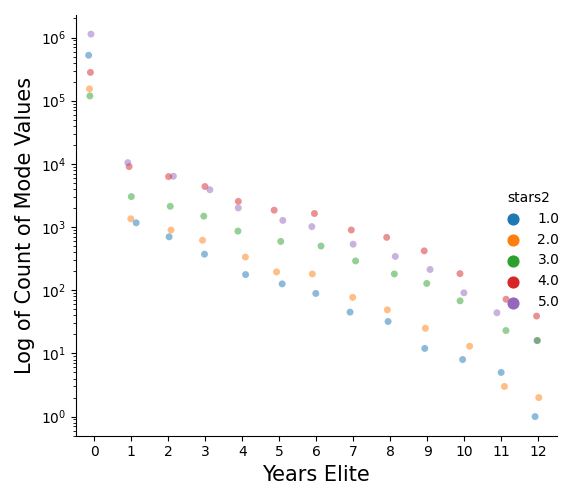

In [21]:
plt.clf()
plt.figure(figsize=(20,10))
plt.title('Probability of a given score being the mode per year spent as an Elite', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)



plt.box(False)
#sb.barplot(elitemode,color="red")
g = sb.catplot(x = 'yrs_elite',y="""count(stars2)""",data=elitemode,kind="strip",alpha=0.5, hue="stars2",jitter=0.15)
plt.yscale('log')
#plt.hist(elitemode)
plt.ylabel("Log of Count of Mode Values",fontsize=15)
plt.xlabel("Years Elite",fontsize=15)
#legend = g.legend
#legend.set_title("Sex")
#legend = plt.legend(handles=[1, 2, 3,4,5], title="title",loc=4, fontsize='small', fancybox=True)
plt.tight_layout()
%matplot plt

The frequency distribution of the mode of a given Elite's ratings has a much larger and more distinct spread than non-elites, with higher ratings being the norm more often, the more years someone has been an Elite. In the population who have never been Elites, 1 star ratings are the second most frquently given rating after 5 star ratings. In every population that has ever been Elites, for however briefly, 1 star ratings are the least or second least frequently given rating, with 4 star and 5 star ratings competing as most frequent rating. This suggests potentially that this behavior is incentivized or else its converse is punished.

---

# In conclusion, the Elite reviews cannot be trusted.